<a href="https://colab.research.google.com/github/Keshav-Sundar-4/RD_ML_Model/blob/main/GrayScott_Toy_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

In [2]:
#@title Get Images

!wget https://raw.githubusercontent.com/Keshav-Sundar-4/RD_ML_Model/main/Spiral_RD.jpeg


--2024-09-22 14:21:48--  https://raw.githubusercontent.com/Keshav-Sundar-4/RD_ML_Model/main/Spiral_RD.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19594 (19K) [image/jpeg]
Saving to: ‘Spiral_RD.jpeg’

Spiral_RD.jpeg      100%[===================>]  19.13K  --.-KB/s    in 0.001s  

2024-09-22 14:21:48 (34.6 MB/s) - ‘Spiral_RD.jpeg’ saved [19594/19594]



In [3]:
#@title Image Manipulation

# Parameters
num_iterations = 5000        # Number of training iterations
image_size = 256             # Size of the grid (image)
dt = 1.0                     # Time step

# Load and preprocess the target image (2D to 4D conversion with noise)
def load_target_image(path, size, num_channels=16, noise_level=0.1):
    # Load image and convert to grayscale
    image = Image.open(path).convert('L')

    # Display the original image
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.show()

    image = image.resize((size, size), Image.Resampling.LANCZOS)
    image = np.array(image) / 255.0  # Normalize to [0,1]

    # Map grayscale intensities to concentrations
    target_A = image  # Concentration of A
    target_B = 1.0 - image  # Concentration of B

    # Convert to torch tensors
    target_A = torch.tensor(target_A, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    target_B = torch.tensor(target_B, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Replicate across channels and add noise to each channel
    target_A_4d = target_A.repeat(1, num_channels, 1, 1) + noise_level * torch.randn_like(target_A.repeat(1, num_channels, 1, 1))
    target_B_4d = target_B.repeat(1, num_channels, 1, 1) + noise_level * torch.randn_like(target_B.repeat(1, num_channels, 1, 1))

    return target_A_4d, target_B_4d



In [4]:
#@title Model Initialization

# Initialize the morphogen concentrations (random 4D tensor)
def initialize_morphogens(size, num_channels=16):
    A = torch.rand(1, num_channels, size, size, requires_grad=True)  # Set requires_grad
    B = torch.rand(1, num_channels, size, size, requires_grad=True)  # Set requires_grad
    return A, B

# Define the convolutional kernel for the Laplacian (diffusion)
def get_laplacian_kernel(num_channels=16):
    laplacian_kernel = torch.tensor([[0.05, 0.2, 0.05],
                                     [0.2, -1.0, 0.2],
                                     [0.05, 0.2, 0.05]], dtype=torch.float32)
    laplacian_kernel = laplacian_kernel.view(1, 1, 3, 3)  # 1 input channel
    laplacian_kernel = laplacian_kernel.repeat(1, num_channels, 1, 1)  # Expand to 16 channels
    return laplacian_kernel



# Reaction-Diffusion Model class
class ReactionDiffusionModel(nn.Module):
    def __init__(self):
        super(ReactionDiffusionModel, self).__init__()
        # Initialize parameters (ensure positivity using logarithm)
        self.Da_log = nn.Parameter(torch.log(torch.tensor(1.0)))
        self.Db_log = nn.Parameter(torch.log(torch.tensor(0.5)))
        self.F_log = nn.Parameter(torch.log(torch.tensor(0.055)))
        self.k_log = nn.Parameter(torch.log(torch.tensor(0.062)))
        self.laplacian_kernel = get_laplacian_kernel()

        # Adding a few convolutional layers to increase parameter count
        self.conv1 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, A, B):
        # Ensure parameters are positive
        Da = torch.exp(self.Da_log)
        Db = torch.exp(self.Db_log)
        F_param = torch.exp(self.F_log)  # Rename the variable
        k = torch.exp(self.k_log)

        # Apply some convolutional layers to A and B
        A = self.relu(self.conv1(A))
        A = self.relu(self.conv2(A))
        B = self.relu(self.conv1(B))
        B = self.relu(self.conv2(B))

        # Compute Laplacian (diffusion)
        A_lap = F.conv2d(A, self.laplacian_kernel, padding=1)
        B_lap = F.conv2d(B, self.laplacian_kernel, padding=1)

        # Reaction terms
        AB2 = A * B * B
        A_diff = (Da * A_lap - AB2 + F_param * (1 - A)) * dt
        B_diff = (Db * B_lap + AB2 - (F_param + k) * B) * dt

        # Update concentrations
        A = A + A_diff
        B = B + B_diff

        # Clamp concentrations to [0,1]
        A = torch.clamp(A, 0.0, 1.0)
        B = torch.clamp(B, 0.0, 1.0)

        return A, B



In [7]:
#@title Training Function

def train(model, target_A, target_B, num_iterations):
    A, B = initialize_morphogens(image_size)  # Initialize morphogens
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Optimizer
    loss_history = []
    display_interval = 500

    for iteration in tqdm(range(num_iterations)):
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        A, B = model(A, B)  # Get model output

        # Compute loss
        loss_A = F.mse_loss(A, target_A)
        loss_B = F.mse_loss(B, target_B)
        loss = loss_A + loss_B

        # Backward pass
        loss.backward(retain_graph=True) # Retain the computation graph
        optimizer.step()

        # Detach A and B from the computation graph
        A = A.detach().requires_grad_(True)
        B = B.detach().requires_grad_(True)

        # Record loss
        loss_history.append(loss.item())

        if (iteration + 1) % display_interval == 0:
            print(f"Iteration {iteration + 1}/{num_iterations}, Loss: {loss.item():.6f}")
            print(f"Da: {torch.exp(model.Da_log).item():.5f}, Db: {torch.exp(model.Db_log).item():.5f}, F: {torch.exp(model.F_log).item():.5f}, k: {torch.exp(model.k_log).item():.5f}")

            output_image = A.mean(dim=1).detach().cpu().numpy().squeeze()  # Generate output image
            plt.figure(figsize=(6, 6))
            plt.imshow(output_image, cmap='gray', vmin=0, vmax=1)
            plt.title(f'Generated Image at Iteration {iteration + 1}')
            plt.axis('off')
            plt.show()

    return A, B, loss_history

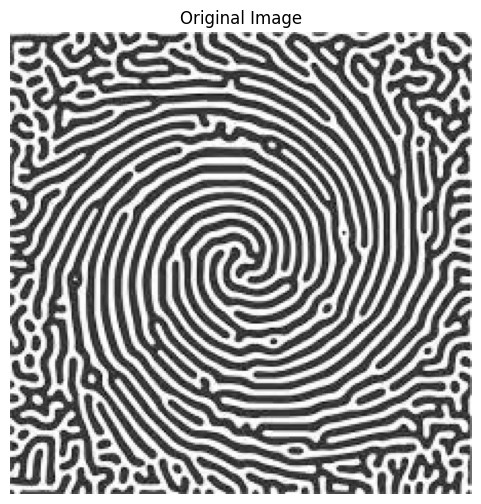

 10%|▉         | 499/5000 [01:47<13:34,  5.52it/s]

Iteration 500/5000, Loss: 0.273124
Da: 0.71611, Db: 0.49844, F: 0.08497, k: 0.06548


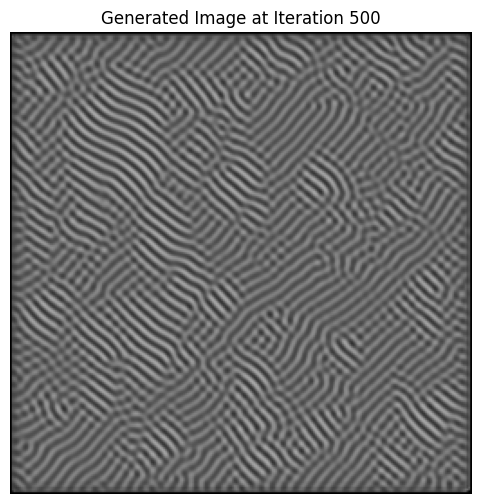

 20%|█▉        | 999/5000 [03:28<12:25,  5.37it/s]

Iteration 1000/5000, Loss: 0.218673
Da: 0.56606, Db: 0.49019, F: 0.13140, k: 0.07768


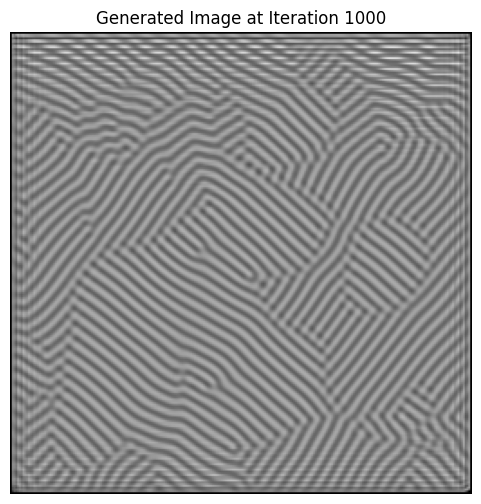

 30%|██▉       | 1499/5000 [05:07<14:31,  4.02it/s]

Iteration 1500/5000, Loss: 0.203166
Da: 0.43838, Db: 0.48404, F: 0.18211, k: 0.08544


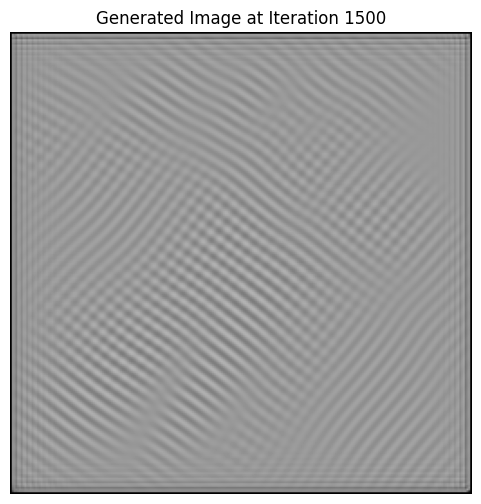

 40%|███▉      | 1999/5000 [06:48<09:22,  5.33it/s]

Iteration 2000/5000, Loss: 0.198229
Da: 0.42826, Db: 0.47923, F: 0.24697, k: 0.08356


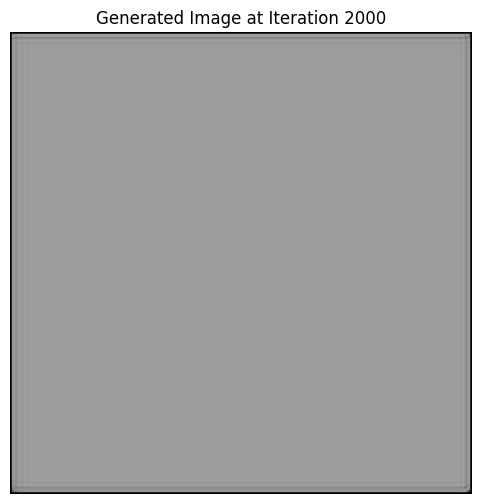

 42%|████▏     | 2082/5000 [07:05<09:56,  4.89it/s]


KeyboardInterrupt: 

In [8]:
#@title Simulation

# Main execution
if __name__ == "__main__":
    # Load target image (grayscale)
    target_image_path = 'Spiral_RD.jpeg'  # Replace with your image path
    target_A, target_B = load_target_image(target_image_path, image_size)

    # Initialize model
    model = ReactionDiffusionModel()

    # Train the model
    A, B, loss_history = train(model, target_A, target_B, num_iterations)

    # Plot the loss graph
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history)
    plt.title('Loss over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()

    # Final output (convert to 2D by averaging across channels)
    output_image = A.mean(dim=1).detach().numpy().squeeze()

    # Display the final generated image
    plt.figure(figsize=(6, 6))
    plt.imshow(output_image, cmap='gray', vmin=0, vmax=1)
    plt.title('Final Generated Image')
    plt.axis('off')
    plt.show()

    # Save the final generated image
    output_pil_image = Image.fromarray((output_image * 255).astype(np.uint8))
    output_pil_image.save('generated_image_grayscale.png')